In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans
import sys
import matplotlib.colors as colors
import os
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
from scipy.io import loadmat

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
curvature_all = ma.abs(thetas_all).mean(axis=1)

In [3]:
n_clusters=1000
f = h5py.File('../data/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters),'r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [4]:
f = h5py.File('../data/Foraging_N2/phspace_K_10_m_7.h5','r')
traj_matrix = ma.masked_invalid(f['traj_matrix'])
phspace = ma.array(f['phspace'])
components = np.array(f['modes'])
traj_matrix[traj_matrix==0]=ma.masked
f.close()

In [5]:
n_neighbors=50;min_dist=.05
f = h5py.File('../data/umap_embeddings/umap_n_{:.1f}_d_{:.2f}.h5'.format(n_neighbors,min_dist),'r')
u_all = ma.masked_invalid(f['umap'])
u_all[u_all==0] = ma.masked
f.close()
u = u_all[:-1000]
centers_umap = u_all[-1000:]

In [6]:
n_clusters=1000
frameRate=16.
dt=1/frameRate

kw=0
f = h5py.File('../data/tscales/results_{}.h5'.format(kw),'r')
delay_range = np.array(f['delay_range'])
n_clusters = np.array(f['n_clusters'],dtype=int)[0]
f.close()
n_modes=100
n_worms=12
n_shuffle=100

ts_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
eigvals_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
ts_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
eigvals_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
for kw in range(n_worms):
    f = h5py.File('../data/tscales/results_{}.h5'.format(kw),'r')
    ts_traj_shuffle[kw] = np.array(f['ts_traj_shuffle'])
    eigvals_traj_shuffle[kw] = np.array(f['eigvals_traj_shuffle'])
    ts_traj_w[kw] = np.array(f['ts_traj_w'])
    eigvals_traj_w[kw] = np.array(f['eigvals_traj_w'])
    f.close()
    
tscales_shuffle_prop_single = np.vstack([-(delay_range*dt)/np.log(eigvals_traj_shuffle[kw,0,0]) for kw in range(n_worms)])

In [7]:
delay_range[11]*dt

0.75

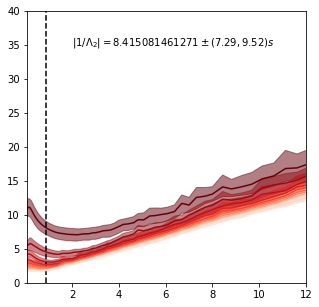

In [8]:
n_worms=12
plt.figure(figsize=(5,5))
n_modes_plot=10
colors_ = plt.cm.Reds_r(np.linspace(0,.9,n_modes_plot))
mean,cil,ciu=stats.bootstrap(ts_traj_w[:,:,0],median=False,n_times=1000)
plt.text(2,35,r'$|1/\Lambda_2| = {:.12f}\pm({:.2f},{:.2f}) s$'.format(mean[11],cil[11],ciu[11]))
plt.axvline(delay_range[13]*dt,c='k',ls='--')
for mode in range(n_modes_plot):
    mean,cil,ciu=stats.bootstrap(ts_traj_w[:,:,mode],median=False,n_times=100)
    plt.plot(delay_range*dt,mean,c=colors_[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])

plt.xlim(dt,12)
plt.ylim(0,40)
# mean,cil,ciu = stats.bootstrap(ts_traj_shuffle[:,:,0],n_times=100)
# plt.plot(delay_range_shuffle*dt,mean,c='k',zorder=1000)
# plt.fill_between(delay_range_shuffle*dt,cil,ciu,alpha=.5,color='k',zorder=1000)
# mean,cil,ciu = stats.bootstrap(tscales_shuffle_prop_single,n_times=100)
# mean,cil,ciu = tscales_shuffle_prop.mean(axis=0),np.percentile(tscales_shuffle_prop,2.5,axis=0),np.percentile(tscales_shuffle_prop,97.5,axis=0)
# plt.plot(delay_range*dt,mean,c='k',zorder=1000)
# plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color='k',zorder=1000)
# plt.savefig('tscales_Foraging_1000_clusters.pdf')
plt.show()


/Users/costa/opt/anaconda3/lib/python3.8/site-packages/matplotlib/patches.py:1074: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


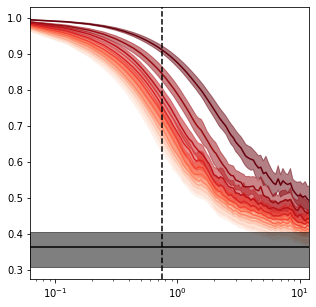

In [9]:
n_modes=10
plt.figure(figsize=(5,5))
colors_ = plt.cm.Reds_r(np.linspace(0,.9,n_modes))

for mode in range(n_modes):
    mean,cil,ciu=stats.bootstrap(eigvals_traj_w[:,:,mode],median=False,n_times=100)
    plt.plot(delay_range*dt,mean,c=colors_[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_[mode])
mean,cil,ciu=stats.bootstrap(eigvals_traj_w[:,:,0],median=False,n_times=1000)
# plt.text(2,35,r'$|1/\Lambda_2| = {:.12f}\pm({:.2f},{:.2f}) s$'.format(mean[11],cil[11],ciu[11]))
plt.axvline(delay_range[11]*dt,c='k',ls='--')
plt.xlim(dt,12)
plt.xscale('log')
mean,cil,ciu = stats.bootstrap(eigvals_traj_shuffle[:,0,0],n_times=100)
plt.axhline(mean,c='k',zorder=1000)
plt.axhspan(cil,ciu,color='k',alpha=.5,zorder=1000)
# plt.fill_between(delay_range_shuffle*dt,cil,ciu,alpha=.5,color='k',zorder=1000)
# plt.savefig('eigvals_Foraging_1000_clusters.pdf')
plt.show()


In [17]:
f = h5py.File('../data/labels_tree/labels_tree.h5','r')
delay = int(np.array(f['delay'])[0])
eigfunctions = np.array(f['eigfunctions'])
f.close()
lcs,P = op_calc.transition_matrix(labels_traj,delay,return_connected=True)
inv_measure = op_calc.stationary_distribution(P)
phi2 = eigfunctions[:,1]
c_range,rho_sets,c_opt,kmeans_labels = op_calc.optimal_partition(phi2,inv_measure,P,return_rho=True)

In [21]:
idx = np.where(c_range==c_opt)[0][0]

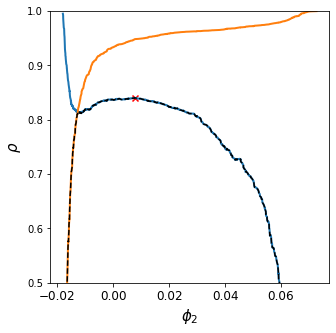

In [23]:
plt.figure(figsize=(5,5))
plt.plot(c_range,rho_sets,lw=2)
rho_c = np.min(rho_sets,axis=1)
plt.plot(c_range,rho_c,c='k',ls='--')
plt.scatter(c_range[idx],rho_c[idx],c='r',marker='x')
plt.ylim(.5,1)
# plt.xlim(-0.04,0.04)
plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\rho$',fontsize=15)
plt.xticks(fontsize=12)
# plt.savefig('rho_2states_Foraging.pdf')
plt.show()

In [24]:
f = h5py.File('../data/labels_tree/labels_tree.h5','r')
delay = int(np.array(f['delay'])[0])
eigfunctions = np.array(f['eigfunctions'])
final_labels = ma.masked_invalid(np.array(f['final_labels'],dtype=int))
final_labels_mask = np.array(f['final_labels_mask'])
sel = final_labels_mask==1
final_labels[sel] = ma.masked
mlg = f['measures']
measures = []
for k in np.sort(list(mlg.keys())):
    measures.append(np.array(mlg[str(k)]))
labels_tree = np.array(f['labels_tree'])
f.close()

eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

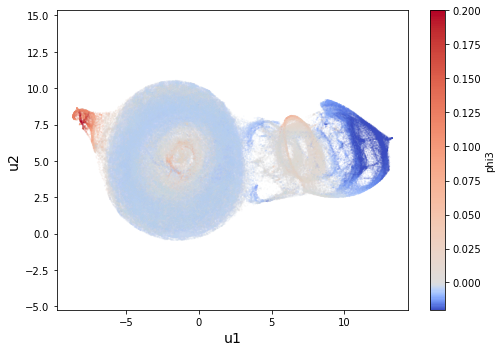

In [25]:
from matplotlib.colors import TwoSlopeNorm
vmin,vmax=-.02,.2
plt.figure(figsize=(7,5))
plt.scatter(u[:,0],u[:,1],s=.003,norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax),c=eigfunctions_traj[:,2],cmap='coolwarm')
plt.colorbar(label = 'phi3')
plt.xlabel('u1',fontsize=14)
plt.ylabel('u2',fontsize=14)
plt.tight_layout()
plt.axis('equal')
# plt.savefig('umap_phi3.png',dpi=500)
plt.show()

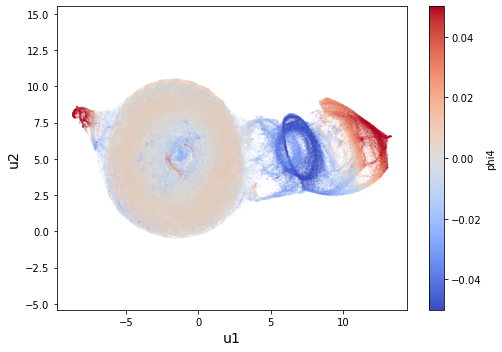

In [26]:
vmin,vmax=-.05,.05
plt.figure(figsize=(7,5))
plt.scatter(u[:,0],u[:,1],s=.003,norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax),c=eigfunctions_traj[:,3],cmap='coolwarm')
plt.colorbar(label = 'phi4')
plt.xlabel('u1',fontsize=14)
plt.ylabel('u2',fontsize=14)
plt.tight_layout()
plt.axis('equal')
plt.savefig('umap_phi4.png',dpi=500)
plt.show()

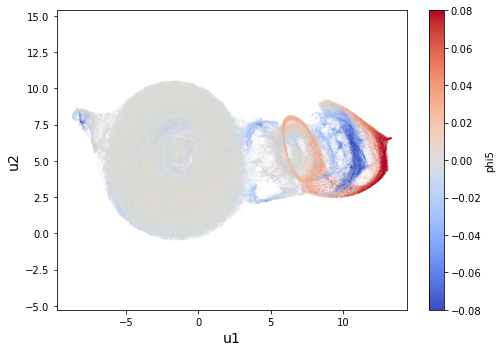

In [27]:
vmin,vmax=-.08,.08
plt.figure(figsize=(7,5))
plt.scatter(u[:,0],u[:,1],s=.003,norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax),c=eigfunctions_traj[:,4],cmap='coolwarm')
plt.colorbar(label = 'phi5')
plt.xlabel('u1',fontsize=14)
plt.ylabel('u2',fontsize=14)
plt.tight_layout()
plt.axis('equal')
plt.savefig('umap_phi5.png',dpi=600)
plt.show()

In [74]:
def get_widths(n_points,worm_length=1,s_skel=100):
    """
    Calculates (x,y) coordinates of the worm centerline from the tangent angle (theta) vector
    """
    num_centerline_joints = n_points
    widths = np.ones(n_points)
    widths[:int(n_points*.2)] = 2*np.linspace(.1,.5,int(n_points*.2))
    widths[int(n_points*.8)-1:] = np.linspace(.01,1,int(n_points*.2)+1)[::-1]
    return widths*s_skel

def plot_skel(skel,widths,s,s_skel,c='k'):
    Xskel = s*(skel-skel.mean(axis=0))
    plt.scatter(Xskel[:,0],Xskel[:,1],c=c,s=widths)
    plt.plot(Xskel[:-1,0],Xskel[:-1,1],c='w',lw=1.5,solid_capstyle='round')
    plt.scatter(Xskel[2,0],Xskel[2,1],c='w',s=s_skel*.08)
    plt.scatter(Xskel[6,0],Xskel[6,1],c='w',s=s_skel*.15)
    plt.plot(Xskel[:6,0],Xskel[:6,1],c='w',lw=.008*s_skel,solid_capstyle='round')
#     plt.axis('equal')
    plt.tight_layout()
    

def calculate_skeleton(theta,worm_length=.01):
    """
    Calculates (x,y) coordinates of the worm centerline from the tangent angle (theta) vector
    """
    num_centerline_joints = len(theta)

    out = np.empty((num_centerline_joints, 2))

    centerline_section_length = worm_length / (num_centerline_joints - 1)
    np.cumsum(
        [
            centerline_section_length * np.cos(theta),
            centerline_section_length * np.sin(theta),
        ],
        axis=1,
        out=out.T,
    )
    return out-out.mean(axis=0)

In [52]:
kmeans_labels = labels_tree[5,:]
print(np.unique(kmeans_labels))
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

[ 0.  1.  2.  3.  4.  5.  6. nan]


116


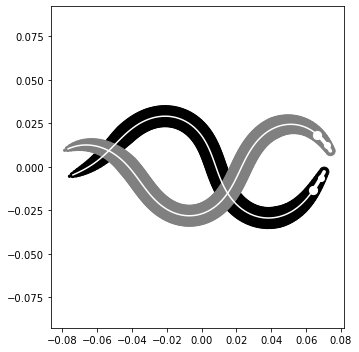

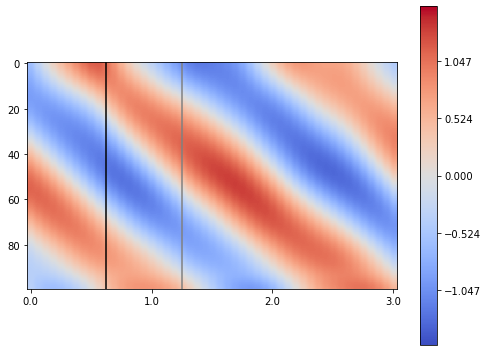

In [75]:
ks=0
s_state = ma.masked_invalid(cluster_traj.copy())
s_state[~(cluster_traj==ks)] = ma.masked
segs = op_calc.segment_maskedArray(s_state)
diffs = np.hstack(np.diff(segs,axis=1))
indices = np.argsort(diffs)[::-1]
t0,tf = segs[indices[0]]
print(tf-t0)

kt=t0+10
s=20
s_skel=450
plt.figure(figsize=(5,5))

widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel)

kt=t0+20
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel,c='gray')
# plt.savefig('fwd_straight_example.pdf')
plt.axis('equal')


plt.figure(figsize=(7,5))
plt.imshow(thetas_all[t0:t0+49].T,aspect=.3,vmax=np.pi/3+.5,vmin=-np.pi/3-.5,cmap='coolwarm')
plt.colorbar(ticks = [-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3])
plt.axvline(10,c='k')
plt.axvline(20,c='gray')
plt.xticks(np.arange(0,49,16),np.arange(0,3.1,1))
plt.tight_layout()
# plt.savefig('theta_fwd_straight.pdf')
plt.show()

54


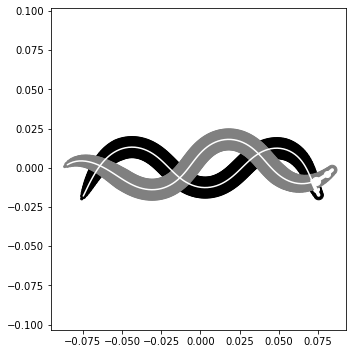

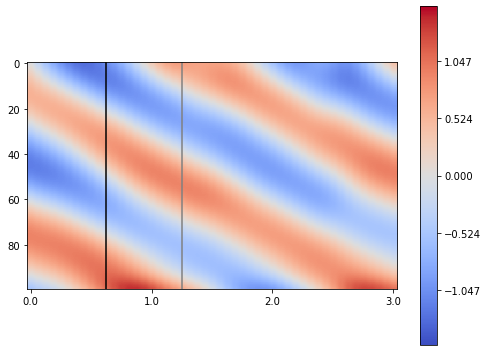

In [76]:
ks=1
s_state = ma.masked_invalid(cluster_traj.copy())
s_state[~(cluster_traj==ks)] = ma.masked
segs = op_calc.segment_maskedArray(s_state)
diffs = np.hstack(np.diff(segs,axis=1))
indices = np.argsort(diffs)[::-1]
t0,tf = segs[indices[0]]
print(tf-t0)

kt=t0+10
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plt.figure(figsize=(5,5))
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel)
plt.axis('equal')
kt=t0+20
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel,c='gray')
# plt.savefig('fwd_loop_example.pdf')

plt.figure(figsize=(7,5))
plt.imshow(thetas_all[t0:t0+49].T,aspect=.3,vmax=np.pi/3+.5,vmin=-np.pi/3-.5,cmap='coolwarm')
plt.colorbar(ticks = [-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3])
plt.xticks(np.arange(0,49,16),np.arange(0,3.1,1))
plt.axvline(10,c='k')
plt.axvline(20,c='gray')
plt.tight_layout()
# plt.savefig('theta_fwd_loop.pdf')
plt.show()

138


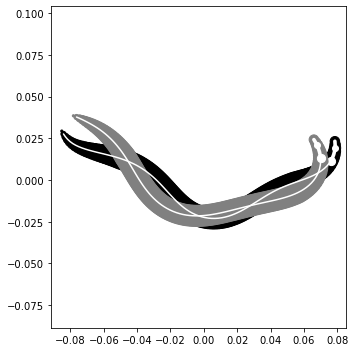

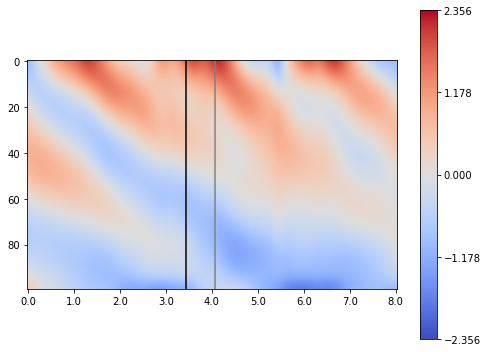

In [77]:
ks=2
s_state = ma.masked_invalid(cluster_traj.copy())
s_state[~(cluster_traj==ks)] = ma.masked
segs = op_calc.segment_maskedArray(s_state)
diffs = np.hstack(np.diff(segs,axis=1))
indices = np.argsort(diffs)[::-1]
t0,tf = segs[indices[0]]
print(tf-t0)


kt=t0+55
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plt.figure(figsize=(5,5))
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel)
plt.axis('equal')
kt=t0+65
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel,c='gray')
# plt.savefig('fwd_dorsal_example.pdf')

plt.figure(figsize=(7,5))
plt.imshow(thetas_all[t0:t0+129].T,aspect=.8,vmax=.75*np.pi,vmin=-.75*np.pi,cmap='coolwarm')
plt.colorbar(ticks = [-0.75*np.pi,-(0.75/2)*np.pi,0,(0.75/2)*np.pi,0.75*np.pi])
plt.axvline(55,c='k')
plt.axvline(65,c='gray')
plt.xticks(np.arange(0,129,16),np.arange(0,8.1,1))
plt.tight_layout()
# plt.savefig('theta_fwd_slow_dorsal.pdf')
plt.show()

133


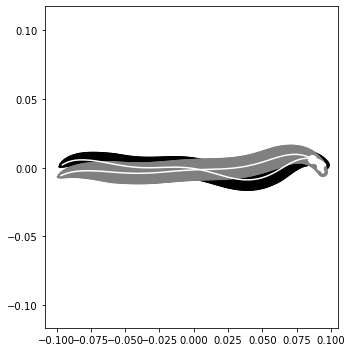

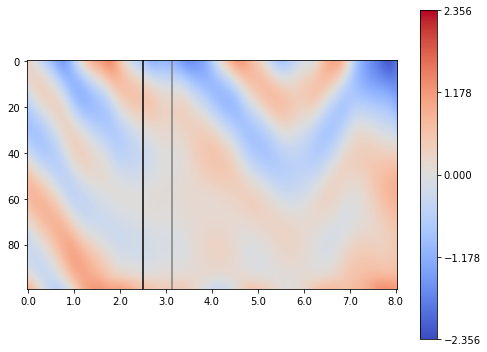

In [78]:
ks=3
s_state = ma.masked_invalid(cluster_traj.copy())
s_state[~(cluster_traj==ks)] = ma.masked
segs = op_calc.segment_maskedArray(s_state)
diffs = np.hstack(np.diff(segs,axis=1))
indices = np.argsort(diffs)[::-1]
t0,tf = segs[indices[0]]
print(tf-t0)

kt=t0+40
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plt.figure(figsize=(5,5))
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel)
plt.axis('equal')
kt=t0+50
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel,c='gray')
# plt.savefig('fwd_ventral_example.pdf')

plt.figure(figsize=(7,5))
plt.imshow(thetas_all[t0:t0+129].T,aspect=.8,vmax=np.pi*.75,vmin=-np.pi*.75,cmap='coolwarm')
plt.colorbar(ticks = [-0.75*np.pi,-(0.75/2)*np.pi,0,(0.75/2)*np.pi,0.75*np.pi])
plt.axvline(40,c='k')
plt.axvline(50,c='gray')
plt.xticks(np.arange(0,129,16),np.arange(0,8.1,1))
plt.tight_layout()
# plt.savefig('theta_fwd_slow_ventral.pdf')
plt.show()

138


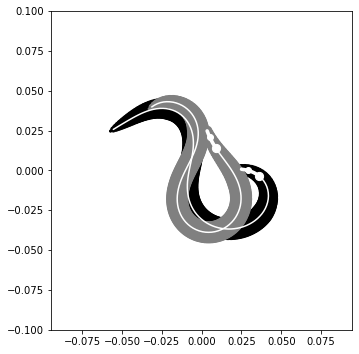

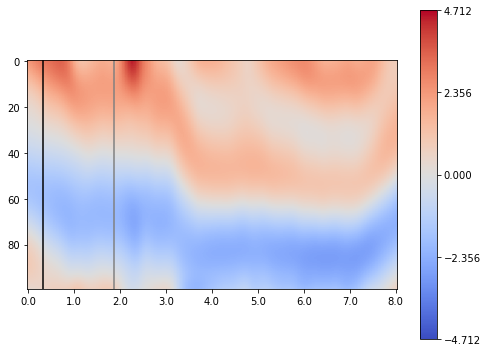

In [79]:
ks=4
s_state = ma.masked_invalid(cluster_traj.copy())
s_state[~(cluster_traj==ks)] = ma.masked
segs = op_calc.segment_maskedArray(s_state)
diffs = np.hstack(np.diff(segs,axis=1))
indices = np.argsort(diffs)[::-1]
t0,tf = segs[indices[0]]
print(tf-t0)


kt=t0+5
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plt.figure(figsize=(5,5))
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel)
plt.axis('equal')
kt=t0+30
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel,c='gray')
plt.xlim(-.1,.1)
plt.ylim(-.1,.1)
# plt.savefig('dorsal_turns_example.pdf')

plt.figure(figsize=(7,5))
plt.imshow(thetas_all[t0:t0+129].T,aspect=.8,vmax=1.5*np.pi,vmin=-1.5*np.pi,cmap='coolwarm')
plt.colorbar(ticks = [-1.5*np.pi,-(0.75)*np.pi,0,(0.75)*np.pi,1.5*np.pi])
plt.axvline(5,c='k')
plt.axvline(30,c='gray')
plt.xticks(np.arange(0,129,16),np.arange(0,8.1,1))
plt.tight_layout()
# plt.savefig('theta_dorsal_turns.pdf')
plt.show()

120


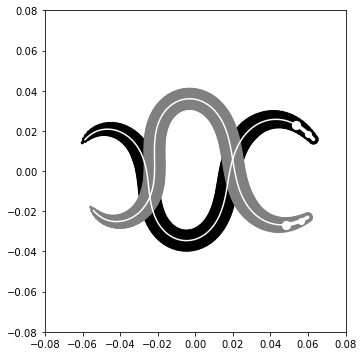

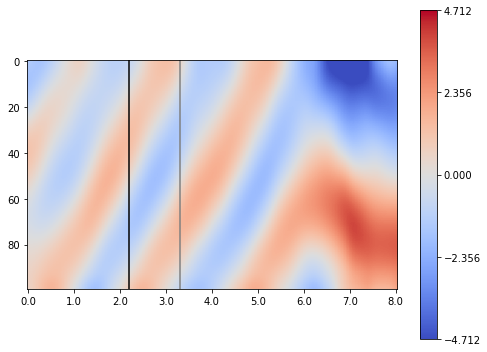

In [80]:
ks=5
s_state = ma.masked_invalid(cluster_traj.copy())
s_state[~(cluster_traj==ks)] = ma.masked
segs = op_calc.segment_maskedArray(s_state)
diffs = np.hstack(np.diff(segs,axis=1))
indices = np.argsort(diffs)[::-1]
t0,tf = segs[indices[1]]
print(tf-t0)



kt=t0+35
s=20
s_skel=450
widths = get_widths(100,s_skel=s_skel)
plt.figure(figsize=(5,5))
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel)

kt=t0+53
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel,c='gray')
# plt.axis('equal')
plt.xlim(-.08,.08)
plt.ylim(-.08,.08)
# plt.savefig('rev_example.pdf')
plt.show()

plt.figure(figsize=(7,5))
plt.imshow(thetas_all[t0:t0+129].T,aspect=.8,vmax=1.5*np.pi,vmin=-1.5*np.pi,cmap='coolwarm')
plt.colorbar(ticks = [-1.5*np.pi,-(0.75)*np.pi,0,(0.75)*np.pi,1.5*np.pi])
plt.axvline(35,c='k')
plt.axvline(53,c='gray')
plt.xticks(np.arange(0,129,16),np.arange(0,8.1,1))
plt.tight_layout()
# plt.savefig('theta_revs.pdf')
plt.show()

138


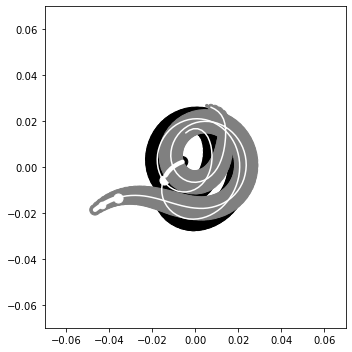

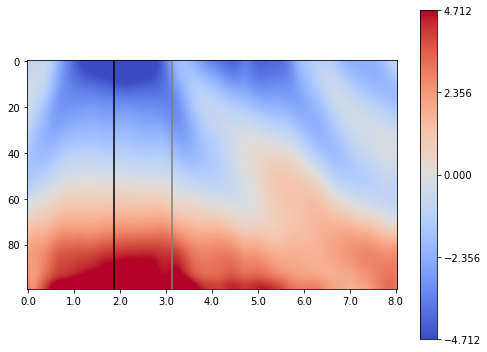

In [93]:
ks=6
s_state = ma.masked_invalid(cluster_traj.copy())
s_state[~(cluster_traj==ks)] = ma.masked
segs = op_calc.segment_maskedArray(s_state)
diffs = np.hstack(np.diff(segs,axis=1))
indices = np.argsort(diffs)[::-1]
t0,tf = segs[indices[1]]
print(tf-t0)



kt=t0+30
s=20
s_skel=550
plt.figure(figsize=(5,5))
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel)

kt=t0+50
widths = get_widths(100,s_skel=s_skel)
plot_skel(-calculate_skeleton(ma.vstack(thetas_w)[kt]),widths,s,s_skel,c='gray')
# plt.savefig('ventral_turn_example.pdf')
plt.xlim(-.07,.07)
plt.ylim(-0.07,.07)

plt.figure(figsize=(7,5))
plt.imshow(thetas_all[t0:t0+129].T,aspect=.8,vmax=1.5*np.pi,vmin=-1.5*np.pi,cmap='coolwarm')
plt.colorbar(ticks = [-1.5*np.pi,-(0.75)*np.pi,0,(0.75)*np.pi,1.5*np.pi])
plt.axvline(30,c='k')
plt.axvline(50,c='gray')
plt.xticks(np.arange(0,129,16),np.arange(0,8.1,1))
plt.tight_layout()
# plt.savefig('theta_ventral_turns.pdf')
plt.show()

In [37]:
colors_states_ = ['#951622','#E30613','#F06600','#F09900','#312783','#1F77B4','#009FE3']
final_states = ['faststraight','fastscurved','slowdorsal','slowventral','dorsal turns','reversals','turns']
subdiv_dict = {'run':['slow','fast'],'fast':['fast_curved','fast_straight'],'slow':['dorsal','ventral'],
              'pirouette':['dorsal','ventral'],'ventral pirouettes':['reversals','turns']}

In [38]:
kmeans_labels = labels_tree[5,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.masked_invalid(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

In [39]:
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])

for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3

omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

curvature_all = ma.abs(thetas_all).mean(axis=1)
thetas_sum = thetas_all.sum(axis=1)

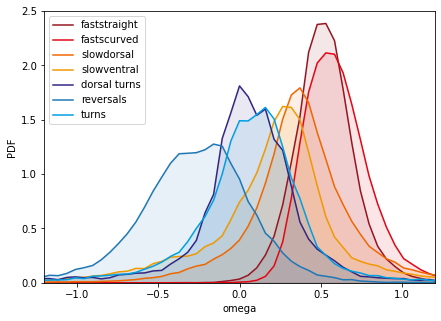

In [40]:
bins=np.linspace(-1.3,1.3,50)
n_states=7
plt.figure(figsize=(7,5))
for kstate in range(n_states):
    sel = cluster_traj==kstate
    freqs,bin_edges = np.histogram(omegas_all[sel],bins,density=True)
    centers = (bin_edges[1:]+bin_edges[:-1])/2
    plt.plot(centers,freqs,c=colors_states_[kstate],label=final_states[kstate])
    plt.fill_between(centers,np.zeros(centers.shape[0]),freqs,color=colors_states_[kstate],alpha=.1)
plt.ylim(0,2.5)
plt.xlim(-1.2,1.2)
plt.xlabel('omega')
plt.ylabel('PDF')
plt.legend()
# plt.savefig('omegas_pdf_states.pdf')
plt.show()

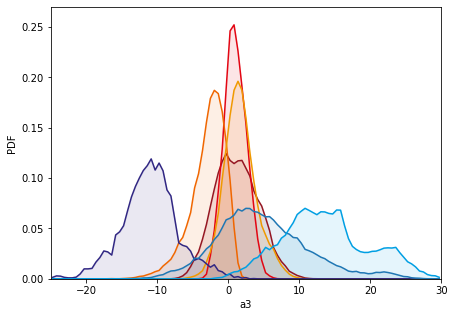

In [41]:
bins=np.linspace(-25,30,100)
n_states=7
plt.figure(figsize=(7,5))

for kstate in range(n_states):
    sel = cluster_traj==kstate
    freqs,bin_edges = np.histogram(a3s_all[sel],bins,density=True)
    centers = (bin_edges[1:]+bin_edges[:-1])/2
    plt.plot(centers,freqs,c=colors_states_[kstate])
    plt.fill_between(centers,np.zeros(centers.shape[0]),freqs,color=colors_states_[kstate],alpha=.1)
plt.ylim(0,.27)
plt.xlim(-25,30)
plt.xlabel('a3')
plt.ylabel('PDF')
# plt.savefig('a3s_pdf_states.pdf')
plt.show()

In [42]:
from scipy.signal import welch
fs=1
max_freqs_state=[]
for kstate in range(2):
    sel = cluster_traj==kstate
    thetas = thetas_all[sel]
    max_freqs = np.zeros(sel.sum())
    for k,x in enumerate(thetas_all[sel]):
        f, Pxx_den = welch(x, fs, nperseg=99,nfft=5000,scaling='spectrum')
        max_freqs[k] = f[np.argmax(Pxx_den)]
    max_freqs_state.append(max_freqs)
    print(kstate)

0
1


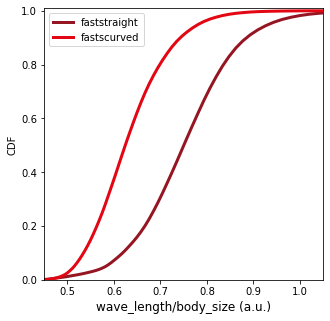

In [43]:
plt.figure(figsize=(5,5))
for kstate in range(2):
    x,y = stats.cumulative_dist(1e-2/np.hstack(max_freqs_state[kstate]),lims=(0,120))
    y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x = np.sort(np.unique(x))
    plt.plot(x,y,c=colors_states_[kstate],label=final_states[kstate],lw=3)
plt.xlabel('wave_length/body_size (a.u.)',fontsize=12)
plt.ylabel('CDF')
plt.xlim(.45,1.05)
plt.ylim(0,1.01)
plt.legend()
# plt.savefig('wave_length_fast_states.pdf')
plt.show()